In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [3]:
pd.set_option('display.max_row', 100)

In [4]:
index = pd.read_csv('data/index_matchmaking.csv', usecols=['Name_big', 'Name_dat'])
index.shape

(6303, 2)

In [5]:
directory = 'BIGFOIL_DAT'
notinbigtable = []
# iterate over files in that directory
for filename in os.listdir(directory):
    if(filename not in index['Name_dat'].to_list()):
        notinbigtable.append(filename)

In [6]:
print(notinbigtable)

['ah93w480b.DAT', 'dga1182.DAT', 'e664ex.DAT', 'fx71l150.DAT', 'fx79w470a.DAT', 'fx79w660a.DAT', 'goe388.DAT', 'goe451.DAT', 'goe802a.DAT', 'goe802b.DAT', 'Horten 10.00% thick 0.50% camber.DAT', 'Horten 10.00% thick 1.50% camber.DAT', 'Horten 10.00% thick 2.50% camber.DAT', 'Horten 10.00% thick 3.50% camber.DAT', 'Horten 10.00% thick 4.50% camber.DAT', 'Horten 10.00% thick 5.50% camber.DAT', 'Horten 10.00% thick 6.50% camber.DAT', 'Horten 10.00% thick 7.50% camber.DAT', 'Horten 10.00% thick 8.50% camber.DAT', 'Horten 10.00% thick 9.50% camber.DAT', 'Horten 10.50% thick 0.00% camber.DAT', 'Horten 10.50% thick 0.50% camber.DAT', 'Horten 10.50% thick 1.00% camber.DAT', 'Horten 10.50% thick 1.50% camber.DAT', 'Horten 10.50% thick 10.00% camber.DAT', 'Horten 10.50% thick 2.00% camber.DAT', 'Horten 10.50% thick 2.50% camber.DAT', 'Horten 10.50% thick 3.00% camber.DAT', 'Horten 10.50% thick 3.50% camber.DAT', 'Horten 10.50% thick 4.00% camber.DAT', 'Horten 10.50% thick 4.50% camber.DAT', 'Hor

In [7]:
# Get the coordinates of a single file dat
# ignore first line as it is the name of the wing
# x coord will have an impair index 
# y coord will have a pair index 
# Return the coordintes either in the form of a list of pair or list of list
def get_coord_wing(filename, format='list', directory='BIGFOIL_DAT'):
    pair_coord, x_list, y_list = [], [], []
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        with open(f, 'r') as f:
            content = f.readlines()
            if (format == 'pair'):
                for line in content[1:]: 
                    split= line.split()
                    pair_coord.append([split[0], split[1]])
                return pair_coord
            else:
                for line in content[1:]:
                    split= line.split()
                    x_list.append(split[0])
                    y_list.append(split[1])
                return [x_list, y_list]
    return None

test = get_coord_wing('a18.DAT')
test_pair= get_coord_wing('a18.DAT', 'pair')

In [8]:
directory = 'BIGFOIL_DAT'
winglist_name = []
winglist_x = []
winglist_y = []
# iterate over files in that directory
for filename in os.listdir(directory):
    if(filename in index['Name_dat'].to_list()):
        winglist_name.append(filename)
        list_coord = get_coord_wing(filename)
        pair_coord = get_coord_wing(filename, 'pair')
        winglist_x.append(list_coord[0])
        winglist_y.append(list_coord[1])

df_index = pd.DataFrame({'name':winglist_name, 'x_coord':winglist_x, 'y_coord':winglist_y})
# df_index.to_csv('xy_coord.csv')
print(df_index.shape[0])


6303


In [9]:
df_index['size_x'] = df_index['x_coord'].map(lambda x: len(x))
df_index['size_y'] = df_index['y_coord'].map(lambda x: len(x))

print('Valeur minimale de size_x : ', df_index['size_x'].min())
print('Valeur maximale de size_x : ', df_index['size_x'].max())
print('Valeur moyenne de size_x : ', df_index['size_x'].mean())
print('Valeur médiane de size_x : ', df_index['size_x'].median())

Valeur minimale de size_x :  25
Valeur maximale de size_x :  497
Valeur moyenne de size_x :  108.33158813263525
Valeur médiane de size_x :  102.0


In [10]:
print("Nombre d'ailes où size_x  > médiane :", df_index['size_x'].value_counts()[df_index['size_x'].value_counts().index > df_index['size_x'].median()].sum())
print("Nombre d'ailes où size_x  < médiane :", df_index['size_x'].value_counts()[df_index['size_x'].value_counts().index < df_index['size_x'].median()].sum())
print("Nombre d'ailes où size_x == médiane :", df_index['size_x'].value_counts()[df_index['size_x'].value_counts().index == df_index['size_x'].median()].sum())

Nombre d'ailes où size_x  > médiane : 1322
Nombre d'ailes où size_x  < médiane : 1930
Nombre d'ailes où size_x == médiane : 3051


En excluant les valeurs supérieures à la médiane de l'échantillonnage, on perd des informations de précision (pas grave)

En revance, en excluant les valeurs inférieures, on infère des informations peut-être inexactes

In [11]:
size = df_index['size_x'].value_counts().sort_values().index.to_list()
count = df_index['size_x'].value_counts().sort_values().values

size_below = df_index['size_x'].value_counts()[df_index['size_x'].value_counts().index < df_index['size_x'].median()].index.to_list()
count_below = df_index['size_x'].value_counts()[df_index['size_x'].value_counts().index < df_index['size_x'].median()].values

size_above = df_index['size_x'].value_counts()[df_index['size_x'].value_counts().index > df_index['size_x'].median()].index.to_list()
count_above = df_index['size_x'].value_counts()[df_index['size_x'].value_counts().index > df_index['size_x'].median()].values

<BarContainer object of 64 artists>

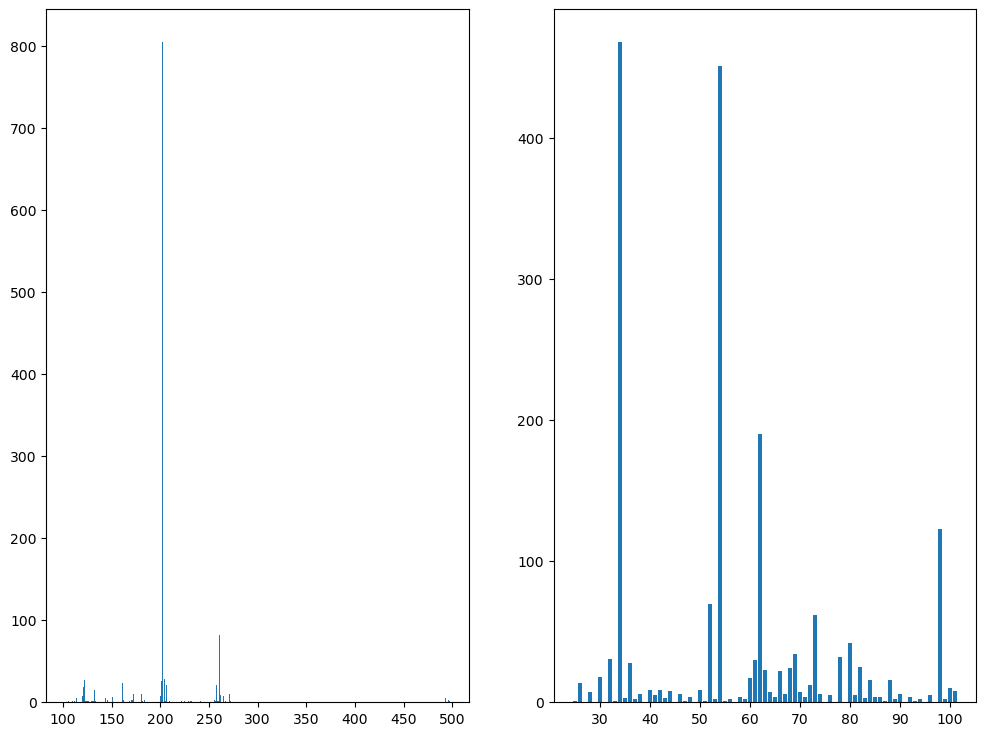

In [12]:
plt.figure(figsize=(12,9))
plt.subplot(121)
plt.bar(size_above, count_above)
plt.subplot(122)
plt.bar(size_below, count_below)

In [13]:
df_median = df_index[df_index['size_x'] == df_index['size_x'].median()]
df_median.shape

(3051, 5)

102
102


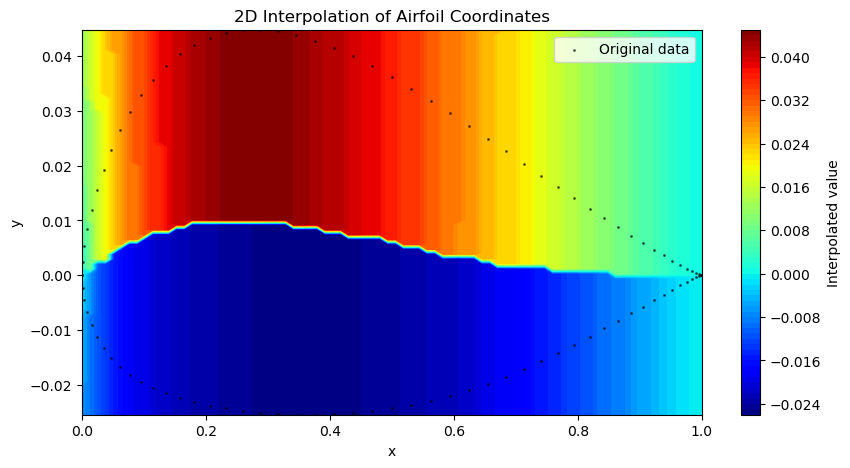

In [18]:
exemple = df_median.loc[df_median['name'] == 'eh1070.DAT', ['x_coord', 'y_coord']]
x = (np.array(exemple['x_coord'].to_numpy()[0])).astype(float)
y = (np.array(exemple['y_coord'].to_numpy()[0])).astype(float)
print(len(x))
print(len(y))
# Ici, on suppose que vous voulez interpoler z sur une grille formée par x et y.
# Dans votre cas, z pourrait être une mesure ou une propriété à ces points.
# Pour l'exemple, utilisons y comme notre 'z' pour l'interpolation.
z = y.copy()

# Création d'une grille régulière sur laquelle interpoler.
# Note : ajustez xi et yi selon la résolution désirée et la plage de vos données.
xi = np.linspace(x.min(), x.max(), 80)
yi = np.linspace(y.min(), y.max(), 80)
xi, yi = np.meshgrid(xi, yi)

# Étape 3 : Interpolation 2D
zi = griddata((x, y), z, (xi, yi), method='nearest')

# Affichage des résultats
plt.figure(figsize=(10, 5))
plt.contourf(xi, yi, zi, levels=80, cmap='jet')
plt.colorbar(label='Interpolated value')
plt.scatter(x, y, marker='.', s=5, color='k', alpha=0.5, label='Original data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Interpolation of Airfoil Coordinates')
plt.show()

In [ ]:
# Notez que griddata nécessite un ensemble de points (x,y) et des valeurs z à ces points, puis interpole ces valeurs sur une nouvelle grille 
# (X,Y). Dans le cas des coordonnées d'ailes d'avion au format Selig, vous pourriez avoir besoin d'interpoler séparément pour la surface supérieure et inférieure si vos données ne sont pas déjà organisées en grille.

In [15]:
zi

array([[-6.810e-03, -9.090e-03, -1.127e-02, ..., -7.100e-04, -3.600e-04,
        -4.000e-05],
       [-6.810e-03, -9.090e-03, -1.127e-02, ..., -7.100e-04, -3.600e-04,
        -4.000e-05],
       [-6.810e-03, -9.090e-03, -1.127e-02, ..., -7.100e-04, -3.600e-04,
        -4.000e-05],
       ...,
       [ 1.192e-02,  1.558e-02,  1.558e-02, ...,  1.210e-03,  3.600e-04,
         3.000e-05],
       [ 1.192e-02,  1.558e-02,  1.558e-02, ...,  1.210e-03,  3.600e-04,
         3.000e-05],
       [ 1.192e-02,  1.558e-02,  1.558e-02, ...,  1.210e-03,  3.600e-04,
         3.000e-05]])

In [16]:
new_x = xi[0]
new_y = yi[:,0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


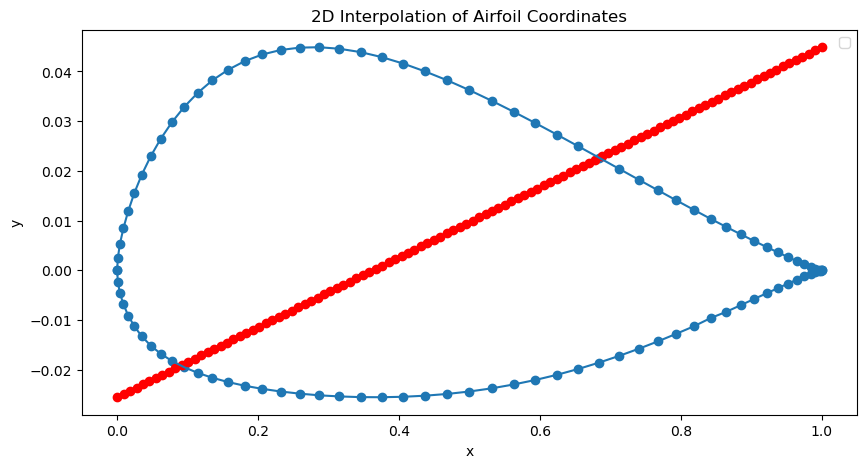

In [17]:
# Affichage des résultats
plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.scatter(x, y)
plt.scatter(new_x, new_y, c='r')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Interpolation of Airfoil Coordinates')
plt.show()

In [20]:
df_index['%_x'] = df_index['size_x'].map(lambda x: x%2)
df_index.head()

,name,x_coord,y_coord,size_x,size_y,%_x
0,a18.DAT,"[1.00000000, 0.95000000, 0.90000000, 0.8000000...","[-0.01251000, -0.00048000, 0.00993000, 0.02759...",42,42,0
1,a18sm.DAT,"[1.00000000, 0.99754000, 0.99070000, 0.9803700...","[0.00307000, 0.00365000, 0.00530000, 0.0077100...",80,80,0
2,A6014-S.DAT,"[1.00000000, 0.99674000, 0.99044000, 0.9831200...","[-0.00002000, 0.00027000, 0.00084000, 0.001510...",271,271,1
3,A6016-S.DAT,"[1.00000000, 0.99673000, 0.99034000, 0.9826600...","[-0.00009000, 0.00022000, 0.00081000, 0.001530...",262,262,0
4,A6018-S.DAT,"[1.00000000, 0.99670000, 0.99014000, 0.9823800...","[0.00000000, 0.00033000, 0.00097000, 0.0017300...",261,261,1


In [26]:
df_index[df_index['%_x'] == 0]

,name,x_coord,y_coord,size_x,size_y,%_x
0,a18.DAT,"[1.00000000, 0.95000000, 0.90000000, 0.8000000...","[-0.01251000, -0.00048000, 0.00993000, 0.02759...",42,42,0
1,a18sm.DAT,"[1.00000000, 0.99754000, 0.99070000, 0.9803700...","[0.00307000, 0.00365000, 0.00530000, 0.0077100...",80,80,0
3,A6016-S.DAT,"[1.00000000, 0.99673000, 0.99034000, 0.9826600...","[-0.00009000, 0.00022000, 0.00081000, 0.001530...",262,262,0
6,a63a108c.DAT,"[1.00000000, 0.99500000, 0.99000000, 0.9800000...","[0.00700000, 0.00700000, 0.00710000, 0.0073000...",100,100,0
7,A6516-S.DAT,"[1.00000000, 0.99662000, 0.99017000, 0.9827000...","[-0.00043000, -0.00009000, 0.00055000, 0.00129...",272,272,0
...,...,...,...,...,...,...
6298,Zone-25.DAT,"[1.00000000, 0.99992000, 0.99944001, 0.9986500...","[0.00115999, 0.00117999, 0.00120999, 0.0012699...",258,258,0
6299,Zone-36.DAT,"[1.00000000, 0.99964000, 0.99914001, 0.9983100...","[0.00078999, 0.00079999, 0.00083999, 0.0008999...",258,258,0
6300,Zone-40.DAT,"[1.00000000, 0.99957000, 0.99905001, 0.9982100...","[0.00052999, 0.00053999, 0.00057999, 0.0006499...",258,258,0
6301,Zone-46.DAT,"[1.00000000, 0.99947001, 0.99895001, 0.9981100...","[0.00049000, 0.00050999, 0.00054999, 0.0006199...",258,258,0


In [24]:
df_index['x_coord']

0       [1.00000000, 0.95000000, 0.90000000, 0.8000000...
1       [1.00000000, 0.99754000, 0.99070000, 0.9803700...
2       [1.00000000, 0.99674000, 0.99044000, 0.9831200...
3       [1.00000000, 0.99673000, 0.99034000, 0.9826600...
4       [1.00000000, 0.99670000, 0.99014000, 0.9823800...
                              ...                        
6298    [1.00000000, 0.99992000, 0.99944001, 0.9986500...
6299    [1.00000000, 0.99964000, 0.99914001, 0.9983100...
6300    [1.00000000, 0.99957000, 0.99905001, 0.9982100...
6301    [1.00000000, 0.99947001, 0.99895001, 0.9981100...
6302    [1.00000000, 0.99935999, 0.99883999, 0.9979999...
Name: x_coord, Length: 6303, dtype: object

In [ ]:
def divise_wing(x, y, modulo):
    if:    
    return x_intrados, x_extrados, y_intrados, y_extrados